In [1]:
from numpy.random import seed
seed(1)
import pickle
import numpy as np
from datetime import datetime
import os

from matplotlib import pyplot as plt
from keras import regularizers, callbacks
from keras.utils.np_utils import to_categorical
from keras.layers import (Input, Dense, Activation, ZeroPadding1D, 
BatchNormalization, Flatten, Reshape, Conv1D, MaxPooling1D, Dropout,Add, LSTM,Embedding)
from keras.initializers import glorot_normal, glorot_uniform
from keras.optimizers import Adam
from keras.models import Model, load_model
# from desispec.interpolation import resample_flux

import math


plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
# plt.rcParamsDefault['axes.prop_cycle']
plt.rcParams['font.size'] = 16
plt.rcParams['axes.grid'] = True
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rc('grid',alpha=0.3,linestyle='--')

Using TensorFlow backend.
/software/python3/3.6.5/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/software/python3/3.6.5/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/software/python3/3.6.5/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/software/python3/3.6.5/lib/python3.6/site-packages/t

In [2]:
from keras import backend as K
def network(input_shape, learning_rate=0.0005, reg=0.0032, dropout=0.7436, seed=None):
    """ 
    Args:
    input_shape -- shape of the input spectra
    regularization_strength -- regularization factor
    dropout -- dropout rate
    seed -- seed of initializer
    Returns:
    model -- a Model() instance in Keras
    """

    X_input = Input(input_shape, name='Input_Spec')

    with K.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)

    with K.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
    with K.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    with K.name_scope('Conv_4'):
        X = Conv1D(filters=64, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

        
    # FLATTEN -> FULLYCONNECTED
    with K.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
    
    with K.name_scope('Output_Layer'):
        X = Dense(1, kernel_regularizer=regularizers.l2(reg),
              activation='sigmoid',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
    model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [3]:
model2 = network((400,1))

In [4]:
import glob
from astropy.io import fits

In [5]:
files_host = np.sort(glob.glob('hosts/*.fits'))
flux_host = []
for f in files_host:
    h = fits.open(f)
    fl = h['BRZ_FLUX'].data
    flux_host.append(fl)
fluxes_hosts_all = np.concatenate(flux_host)
fluxes_hosts=[]
bad_host_counter=0
for i in fluxes_hosts_all:
    if np.sum(i)==0 or math.isnan(np.sum(i)):
        bad_host_counter=bad_host_counter+1
    else:
        fluxes_hosts.append(i)
fluxes_hosts=np.asarray(fluxes_hosts)

subspec_hosts = np.mean(fluxes_hosts[:,:6000].reshape(-1,400,15),2)
maxflux = subspec_hosts.max(axis=-1).reshape(-1,1)
minflux = subspec_hosts.min(axis=-1).reshape(-1,1)
standarized_hosts = (subspec_hosts - minflux)/(maxflux-minflux)

In [6]:
files = np.sort(glob.glob('sneia/*.fits'))
flux = []
for f in files:
    h = fits.open(f)
    f = h['BRZ_FLUX'].data
    zeros = np.zeros(400)
    flux.append(f)
fluxes_all = np.concatenate(flux)
fluxes=[]
bad_SN_counter=0
for i in fluxes_all:
    if np.sum(i)==0 or math.isnan(np.sum(i)):
        bad_SN_counter=bad_SN_counter+1
    else:
        fluxes.append(i)
fluxes=np.asarray(fluxes)

subspec = np.mean(fluxes[:,:6000].reshape(-1,400,15),2)
maxflux = subspec.max(axis=-1).reshape(-1,1)
minflux = subspec.min(axis=-1).reshape(-1,1)
standarized = (subspec - minflux)/(maxflux-minflux)

In [7]:
x_train = np.concatenate([standarized,standarized_hosts]).reshape(-1,400,1)
y_train = np.concatenate([np.zeros(standarized.shape[0]),np.ones(standarized_hosts.shape[0])])
permute = np.random.permutation(y_train.shape[0])

In [8]:
hist = model2.fit(x_train[permute][:30000],y_train[permute][:30000],batch_size=64,epochs=50,
                  validation_split=0.1,shuffle=True)

Train on 17939 samples, validate on 1994 samples
Epoch 1/50
17939/17939 [==============================] - 24s 1ms/step - loss: 1.8006 - acc: 0.6396 - val_loss: 1.3593 - val_acc: 0.6936
Epoch 2/50
17939/17939 [==============================] - 21s 1ms/step - loss: 1.1906 - acc: 0.6868 - val_loss: 0.9963 - val_acc: 0.7277
Epoch 3/50
17939/17939 [==============================] - 21s 1ms/step - loss: 0.9172 - acc: 0.7177 - val_loss: 0.7960 - val_acc: 0.7462
Epoch 4/50
17939/17939 [==============================] - 21s 1ms/step - loss: 0.7640 - acc: 0.7517 - val_loss: 0.6857 - val_acc: 0.7688
Epoch 5/50
17939/17939 [==============================] - 21s 1ms/step - loss: 0.6680 - acc: 0.7695 - val_loss: 0.6476 - val_acc: 0.7643
Epoch 6/50
17939/17939 [==============================] - 21s 1ms/step - loss: 0.6140 - acc: 0.7862 - val_loss: 0.6020 - val_acc: 0.7703
Epoch 7/50
17939/17939 [==============================] - 21s 1ms/step - loss: 0.5752 - acc: 0.7943 - val_loss: 0.5513 - val_acc:

Text(0.5,1,'acc vs epoch')

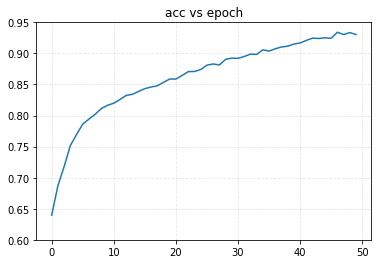

In [13]:
plt.plot(hist.history['acc'])
plt.ylim(.6,.95)
plt.show
plt.title("acc vs epoch")

Text(0.5,1,'val_acc vs epoch')

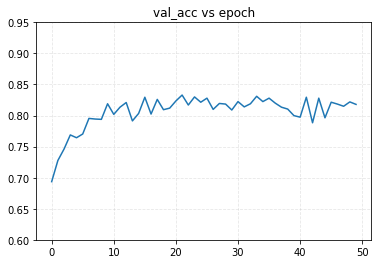

In [14]:
plt.plot(hist.history['val_acc'])
plt.ylim(.6,.95)
plt.show
plt.title("val_acc vs epoch")